In [1]:
import copy
import matplotlib.pyplot as plt
import numpy as np
from typing import Dict, List
import time
import torch
import tqdm

from utils.utils import net_time, plot
from utils.dataloader import VOCDataLoaderPerson
from utils.loss import YoloLoss
from utils.ap import precision_recall_levels, ap, preprocess_for_ap
from utils.yolo import nms, filter_boxes
from utils.viz import display_result

from models.pruned_my_tinyyolo2 import PrunedMyTinyYoloV2
from models.my_tinyyolov2 import MyTinyYoloV2

from utils.train import train, validate

#device = torch.device("cpu")
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

/home/artemis/.local/lib/python3.12/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/artemis/.local/lib/python3.12/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
def densify_state_dict(state_dict: Dict) -> Dict:
    state_dict = copy.deepcopy(state_dict)
    
    mask = None
        
    for layer in range(1, 10):
        l = "conv" + str(layer) + "."
        w = l + "weight"
        b = l + "bias"
        weights = state_dict[w]
        biases = state_dict[b]
        if mask is not None:
            weights = weights[:,mask,:,:]
        mask = torch.nonzero(weights.sum(dim=[1,2,3]), as_tuple=True)[0].tolist()

        weights = weights[mask,:,:,:]
        biases = biases[mask]
        
        state_dict[w] = weights
        state_dict[b] = biases
    
    '''weights = state_dict["fc.weight"]
    
    fcmask = []
    for channel in mask:
        for i in range(4):
            fcmask.append(channel * 4 + i)
    
    state_dict["fc.weight"] = weights[:,fcmask]'''
    
    
    return state_dict

In [3]:
def l1_structured_pruning(state_dict: Dict, prune_ratio: float) -> Dict:
    state_dict = copy.deepcopy(state_dict)
    
    for layer in range(2, 9):
        l = "conv" + str(layer) + "."
        w = l + "weight"
        b = l + "bias"
        weights = state_dict[w]
        biases = state_dict[b]
        number_channels = weights.size()[0]
        number_channels_to_prune = int(number_channels * prune_ratio)
        if number_channels_to_prune < 1:
            continue
        l1 = torch.sum(torch.abs(weights), [1, 2, 3])
        zero_out_channels = torch.argsort(l1)
        
        for i in range(number_channels_to_prune):
            weights[zero_out_channels[i],:,:,:] = 0
            biases[zero_out_channels[i]] = 0
            
        state_dict[w] = weights
        state_dict[b] = biases
    
    
    return state_dict

In [4]:
def plot_losses_over_time(losses, times):
    #losses = np.mean(np.array(losses), axis=0)
    #times = np.mean(np.array(times), axis=0)

    plt.plot(times, losses, 'o')
    #plt.xlim((0,1.1))
    #plt.ylim((0,1.1))
    plt.ylabel('Loss/test')
    plt.xlabel('Times/test')
    plt.title('Losses over inference times')
    plt.show()

Epoch 1/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.13s/it]


average train losses 4.069513056013319
Epoch 2/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.06s/it]


average train losses 3.989069143931071
Epoch 3/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.08s/it]


average train losses 4.064981301625569
Epoch 4/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.07s/it]


average train losses 4.018442021475898
Epoch 5/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.07s/it]


average train losses 4.152978817621867
Epoch 6/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.10s/it]


average train losses 3.728849238819546
Epoch 7/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.07s/it]


average train losses 0.9649663037723966
Epoch 8/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.06s/it]


average train losses 0.963968124654558
Epoch 9/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.09s/it]


average train losses 0.9769265784157647
Epoch 10/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.11s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:05<00:00, 65.38it/s]


average time 0.0014766838475849555
average test losses 2.016410919293719
average precision 0.4544014299808334
average train losses 0.9729410939746432
Epoch 11/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.08s/it]


average train losses 1.2164349026150174
Epoch 12/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.11s/it]


average train losses 1.2108421855502658
Epoch 13/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.07s/it]


average train losses 1.2184948788748846
Epoch 14/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.07s/it]


average train losses 1.227646443578932
Epoch 15/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.08s/it]


average train losses 1.2244519260194566
Epoch 16/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.07s/it]


average train losses 1.2071460088094075
Epoch 17/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.09s/it]


average train losses 1.2209416495429144
Epoch 18/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.11s/it]


average train losses 1.2294543849097357
Epoch 19/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.07s/it]


average train losses 1.20621747440762
Epoch 20/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.07s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:06<00:00, 54.68it/s]


average time 0.0014581286329829115
average test losses 1.9918421060271412
average precision 0.43026157653345365
average train losses 1.2162560754352145
Epoch 21/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.07s/it]


average train losses 1.6581209633085463
Epoch 22/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.09s/it]


average train losses 1.6531403991911147
Epoch 23/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.08s/it]


average train losses 1.6747553613450792
Epoch 24/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.11s/it]


average train losses 1.654345194498698
Epoch 25/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.10s/it]


average train losses 1.662115838792589
Epoch 26/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.09s/it]


average train losses 1.653505802154541
Epoch 27/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.09s/it]


average train losses 1.6955713695949979
Epoch 28/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.09s/it]


average train losses 1.7083439694510565
Epoch 29/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.09s/it]


average train losses 1.6599542962180243
Epoch 30/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.14s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:11<00:00, 30.54it/s]


average time 0.0015720451659286803
average test losses 2.190451053217945
average precision 0.42645989475036905
average train losses 1.6531277100245159
Epoch 31/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.09s/it]


average train losses 1.8914772272109985
Epoch 32/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.09s/it]


average train losses 1.89981030093299
Epoch 33/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.09s/it]


average train losses 1.9063403473960028
Epoch 34/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.08s/it]


average train losses 1.9333119127485487
Epoch 35/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.11s/it]


average train losses 1.9147828817367554
Epoch 36/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.10s/it]


average train losses 1.9313964313930936
Epoch 37/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.09s/it]


average train losses 1.880912595325046
Epoch 38/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.10s/it]


average train losses 1.9240105549494426
Epoch 39/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.09s/it]


average train losses 1.913121885723538
Epoch 40/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.07s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:13<00:00, 25.95it/s]


average time 0.0015501174492034478
average test losses 2.484810915258196
average precision 0.40183228410701477
average train losses 1.902235084109836
Epoch 41/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.07s/it]


average train losses 2.182448943456014
Epoch 42/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.10s/it]


average train losses 2.1718132495880127
Epoch 43/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.09s/it]


average train losses 2.1542464627159967
Epoch 44/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.09s/it]


average train losses 2.1448570489883423
Epoch 45/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.09s/it]


average train losses 2.1494939592149525
Epoch 46/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.10s/it]


average train losses 2.1727257569630942
Epoch 47/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.10s/it]


average train losses 2.154232449001736
Epoch 48/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.11s/it]


average train losses 2.1672666470209756
Epoch 49/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.10s/it]


average train losses 2.1567534605662027
Epoch 50/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.09s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:13<00:00, 25.23it/s]


average time 0.00156844035852329
average test losses 2.817954750821801
average precision 0.38223524691157246
average train losses 2.163642512427436
Epoch 51/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.09s/it]


average train losses 2.4602148797776966
Epoch 52/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.08s/it]


average train losses 2.453619639078776
Epoch 53/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.08s/it]


average train losses 2.455807818306817
Epoch 54/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.08s/it]


average train losses 2.4620515505472818
Epoch 55/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.09s/it]


average train losses 2.420379532708062
Epoch 56/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.11s/it]


average train losses 2.444909519619412
Epoch 57/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:11<00:00,  1.28s/it]


average train losses 2.4547859562767878
Epoch 58/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.20s/it]


average train losses 2.4486616717444525
Epoch 59/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:11<00:00,  1.24s/it]


average train losses 2.450888501273261
Epoch 60/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:11<00:00,  1.23s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:14<00:00, 24.78it/s]


average time 0.0019169811509613297
average test losses 2.7965920046184136
average precision 0.3401483441858165
average train losses 2.4460475974612765
Epoch 61/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.20s/it]


average train losses 2.605442312028673
Epoch 62/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.19s/it]


average train losses 2.6021403206719294
Epoch 63/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.22s/it]


average train losses 2.611709223853217
Epoch 64/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.17s/it]


average train losses 2.609127680460612
Epoch 65/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.21s/it]


average train losses 2.614658620622423
Epoch 66/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:11<00:00,  1.24s/it]


average train losses 2.6122699048784046
Epoch 67/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:11<00:00,  1.24s/it]


average train losses 2.5937117205725775
Epoch 68/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.20s/it]


average train losses 2.6043032010396323
Epoch 69/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.18s/it]


average train losses 2.6135195361243353
Epoch 70/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:11<00:00,  1.23s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:14<00:00, 24.61it/s]


average time 0.0016142058576274123
average test losses 2.961150283827062
average precision 0.2778939833225688
average train losses 2.6212543646494546
Epoch 71/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.20s/it]


average train losses 2.8055500189463296
Epoch 72/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:11<00:00,  1.24s/it]


average train losses 2.828276369306776
Epoch 73/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.21s/it]


average train losses 2.8473577764299183
Epoch 74/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.20s/it]


average train losses 2.847471581565009
Epoch 75/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.22s/it]


average train losses 2.820854557885064
Epoch 76/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.18s/it]


average train losses 2.835979779561361
Epoch 77/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:11<00:00,  1.22s/it]


average train losses 2.827869865629408
Epoch 78/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:11<00:00,  1.23s/it]


average train losses 2.8240357769860163
Epoch 79/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:11<00:00,  1.23s/it]


average train losses 2.8407884438832602
Epoch 80/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.19s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:16<00:00, 21.61it/s]


average time 0.0016557477478288177
average test losses 3.182159653756014
average precision 0.26542773048629653
average train losses 2.8202674123975964
Epoch 81/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.20s/it]


average train losses 3.074067619111803
Epoch 82/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.21s/it]


average train losses 3.049567937850952
Epoch 83/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.21s/it]


average train losses 3.057183133231269
Epoch 84/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.21s/it]


average train losses 3.066492372088962
Epoch 85/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.17s/it]


average train losses 3.072536097632514
Epoch 86/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.20s/it]


average train losses 3.065010335710314
Epoch 87/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:11<00:00,  1.25s/it]


average train losses 3.0586560832129583
Epoch 88/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.21s/it]


average train losses 3.068419403500027
Epoch 89/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.18s/it]


average train losses 3.1058166291978626
Epoch 90/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:11<00:00,  1.26s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:15<00:00, 22.69it/s]


average time 0.0017129899429799485
average test losses 3.3084362650189303
average precision 0.28006383021531833
average train losses 3.057686063978407
Epoch 91/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.18s/it]


average train losses 3.079818328221639
Epoch 92/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.16s/it]


average train losses 3.089387893676758
Epoch 93/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:11<00:00,  1.23s/it]


average train losses 3.0658281909094915
Epoch 94/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:12<00:00,  1.34s/it]


average train losses 3.050587601131863
Epoch 95/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:11<00:00,  1.33s/it]


average train losses 3.0867376062605114
Epoch 96/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:11<00:00,  1.29s/it]


average train losses 3.0867161220974393
Epoch 97/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:11<00:00,  1.28s/it]


average train losses 3.052495797475179
Epoch 98/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:11<00:00,  1.28s/it]


average train losses 3.0611209869384766
Epoch 99/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:11<00:00,  1.25s/it]


average train losses 3.0691605938805475
Epoch 100/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:11<00:00,  1.26s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:19<00:00, 17.83it/s]


average time 0.003088909676271966
average test losses 3.285565217336019
average precision 0.261096913421581
average train losses 3.0539301766289606
Epoch 101/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:11<00:00,  1.32s/it]


average train losses 3.142022318310208
Epoch 102/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:11<00:00,  1.31s/it]


average train losses 3.1248709890577526
Epoch 103/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:11<00:00,  1.30s/it]


average train losses 3.129048506418864
Epoch 104/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:11<00:00,  1.27s/it]


average train losses 3.1424612998962402
Epoch 105/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:11<00:00,  1.33s/it]


average train losses 3.1327989631228976
Epoch 106/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:12<00:00,  1.39s/it]


average train losses 3.1329222785101996
Epoch 107/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:12<00:00,  1.36s/it]


average train losses 3.1682524416181774
Epoch 108/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:12<00:00,  1.39s/it]


average train losses 3.1494476000467935
Epoch 109/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:12<00:00,  1.37s/it]


average train losses 3.124227285385132
Epoch 110/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:12<00:00,  1.41s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:20<00:00, 17.09it/s]


average time 0.00396611004473477
average test losses 3.2948702709627287
average precision 0.19177502279025632
average train losses 3.136895868513319
Epoch 111/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:12<00:00,  1.38s/it]


average train losses 3.1631370650397406
Epoch 112/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:12<00:00,  1.40s/it]


average train losses 3.18969021903144
Epoch 113/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:12<00:00,  1.43s/it]


average train losses 3.183134502834744
Epoch 114/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:12<00:00,  1.40s/it]


average train losses 3.1813365353478327
Epoch 115/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.21s/it]


average train losses 3.213038523991903
Epoch 116/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.18s/it]


average train losses 3.1953239970737033
Epoch 117/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.19s/it]


average train losses 3.1974917782677545
Epoch 118/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:11<00:00,  1.23s/it]


average train losses 3.176448927985297
Epoch 119/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.21s/it]


average train losses 3.205897675620185
Epoch 120/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:11<00:00,  1.25s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:16<00:00, 21.37it/s]


average time 0.0017079063969799597
average test losses 3.4816126015111593
average precision 0.1447952351104219
average train losses 3.207213136884901
Epoch 121/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.18s/it]


average train losses 3.3422984547085233
Epoch 122/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.20s/it]


average train losses 3.3509786128997803
Epoch 123/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:11<00:00,  1.24s/it]


average train losses 3.3501297103034124
Epoch 124/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.21s/it]


average train losses 3.3533346917894153
Epoch 125/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.19s/it]


average train losses 3.3279643853505454
Epoch 126/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.19s/it]


average train losses 3.336705658170912
Epoch 127/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.17s/it]


average train losses 3.36540953318278
Epoch 128/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.20s/it]


average train losses 3.3300988939073353
Epoch 129/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:11<00:00,  1.23s/it]


average train losses 3.3399164411756725
Epoch 130/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.17s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:16<00:00, 21.66it/s]


average time 0.0017396568233131343
average test losses 3.355734167615233
average precision 0.1518454055099257
average train losses 3.3668061097462973
Epoch 131/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.18s/it]


average train losses 3.5574309825897217
Epoch 132/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:11<00:00,  1.24s/it]


average train losses 3.5682566430833607
Epoch 133/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.22s/it]


average train losses 3.550636476940579
Epoch 134/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.21s/it]


average train losses 3.5428511831495495
Epoch 135/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.18s/it]


average train losses 3.5636999342176647
Epoch 136/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.19s/it]


average train losses 3.5769084559546576
Epoch 137/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.17s/it]


average train losses 3.574477195739746
Epoch 138/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.18s/it]


average train losses 3.5767931673261852
Epoch 139/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.17s/it]


average train losses 3.584551069471571
Epoch 140/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.22s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:16<00:00, 20.59it/s]


average time 0.0017212551203888025
average test losses 3.588547597243915
average precision 0.14886714773086832
average train losses 3.576030280854967
Epoch 141/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.22s/it]


average train losses 3.9333591196272106
Epoch 142/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.22s/it]


average train losses 3.9415923489464655
Epoch 143/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.19s/it]


average train losses 3.918442381752862
Epoch 144/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.20s/it]


average train losses 3.929529587427775
Epoch 145/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.18s/it]


average train losses 3.9463963508605957
Epoch 146/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.21s/it]


average train losses 3.9135989083184137
Epoch 147/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.19s/it]


average train losses 3.9675368203057184
Epoch 148/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:11<00:00,  1.26s/it]


average train losses 3.931961907280816
Epoch 149/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:11<00:00,  1.29s/it]


average train losses 3.910655392540826
Epoch 150/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:11<00:00,  1.25s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:21<00:00, 16.38it/s]


average time 0.001973222803186487
average test losses 4.096216281934342
average precision 0.13507019737753875
average train losses 3.937986797756619
Epoch 151/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.20s/it]


average train losses 4.012807528177897
Epoch 152/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.21s/it]


average train losses 3.999905268351237
Epoch 153/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.22s/it]


average train losses 3.9795947869618735
Epoch 154/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:11<00:00,  1.26s/it]


average train losses 3.992503696017795
Epoch 155/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:11<00:00,  1.25s/it]


average train losses 3.978884776433309
Epoch 156/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:11<00:00,  1.26s/it]


average train losses 4.005100753572252
Epoch 157/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:11<00:00,  1.26s/it]


average train losses 3.9882758458455405
Epoch 158/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:11<00:00,  1.32s/it]


average train losses 3.992697662777371
Epoch 159/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:12<00:00,  1.41s/it]


average train losses 3.9784362845950656
Epoch 160/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:11<00:00,  1.33s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:23<00:00, 14.65it/s]


average time 0.002736609206240401
average test losses 4.066430768735728
average precision 0.13393412132759971
average train losses 3.9843526946173773
Epoch 161/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:11<00:00,  1.31s/it]


average train losses 4.62047979566786
Epoch 162/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:11<00:00,  1.29s/it]


average train losses 4.62657806608412
Epoch 163/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:11<00:00,  1.27s/it]


average train losses 4.638450516594781
Epoch 164/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:11<00:00,  1.31s/it]


average train losses 4.646792782677545
Epoch 165/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:11<00:00,  1.33s/it]


average train losses 4.641960197024876
Epoch 166/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:11<00:00,  1.33s/it]


average train losses 4.6389744016859265
Epoch 167/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:12<00:00,  1.35s/it]


average train losses 4.649557696448432
Epoch 168/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:11<00:00,  1.27s/it]


average train losses 4.642604404025608
Epoch 169/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:11<00:00,  1.25s/it]


average train losses 4.623664485083686
Epoch 170/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.20s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:23<00:00, 14.84it/s]


average time 0.0019975367434683687
average test losses 4.806473333951075
average precision 0.12320825638066123
average train losses 4.605073187086317
Epoch 171/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:11<00:00,  1.24s/it]


average train losses 5.125451564788818
Epoch 172/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.20s/it]


average train losses 5.114604261186388
Epoch 173/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:11<00:00,  1.24s/it]


average train losses 5.114298555586073
Epoch 174/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.20s/it]


average train losses 5.108108096652561
Epoch 175/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:11<00:00,  1.23s/it]


average train losses 5.107306745317247
Epoch 176/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:11<00:00,  1.24s/it]


average train losses 5.128086302015516
Epoch 177/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:11<00:00,  1.25s/it]


average train losses 5.13557948006524
Epoch 178/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.21s/it]


average train losses 5.150047673119439
Epoch 179/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:13<00:00,  1.45s/it]


average train losses 5.101211600833469
Epoch 180/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.16s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:22<00:00, 15.48it/s]


average time 0.0017195556238505914
average test losses 5.176369355954336
average precision 0.1237253503122072
average train losses 5.108319494459364
Epoch 181/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:19<00:00,  2.18s/it]


average train losses 5.471568849351671
Epoch 182/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.17s/it]


average train losses 5.4828728040059405
Epoch 183/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.17s/it]


average train losses 5.501959853702122
Epoch 184/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.20s/it]


average train losses 5.490916993882921
Epoch 185/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.20s/it]


average train losses 5.498393747541639
Epoch 186/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.18s/it]


average train losses 5.483065022362603
Epoch 187/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.17s/it]


average train losses 5.507667965359158
Epoch 188/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.17s/it]


average train losses 5.487256315019396
Epoch 189/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.20s/it]


average train losses 5.497293260362413
Epoch 190/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.19s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:22<00:00, 15.69it/s]


average time 0.0019298523579567585
average test losses 5.484234571456909
average precision 0.17903582081543737
average train losses 5.467170662350124
Epoch 191/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:19<00:00,  2.15s/it]


average train losses 5.894013404846191
Epoch 192/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:11<00:00,  1.23s/it]


average train losses 5.885015434688992
Epoch 193/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.21s/it]


average train losses 5.865064197116428
Epoch 194/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.19s/it]


average train losses 5.85958014594184
Epoch 195/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:11<00:00,  1.26s/it]


average train losses 5.8812605539957685
Epoch 196/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.21s/it]


average train losses 5.894079632229275
Epoch 197/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.18s/it]


average train losses 5.889609548780653
Epoch 198/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.19s/it]


average train losses 5.871018250783284
Epoch 199/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.21s/it]


average train losses 5.886607964833577
Epoch 200/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.18s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:25<00:00, 13.49it/s]


average time 0.0020201606967849947
average test losses 5.955038146076039
average precision 0.17020435430469968
average train losses 5.870304955376519
Epoch 201/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:18<00:00,  2.06s/it]


average train losses 6.3203426996866865
Epoch 202/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.18s/it]


average train losses 6.3043323092990455
Epoch 203/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.19s/it]


average train losses 6.304147508409288
Epoch 204/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.19s/it]


average train losses 6.305605941348606
Epoch 205/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.18s/it]


average train losses 6.320817947387695
Epoch 206/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:11<00:00,  1.24s/it]


average train losses 6.285253418816461
Epoch 207/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:11<00:00,  1.22s/it]


average train losses 6.299837536282009
Epoch 208/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:11<00:00,  1.22s/it]


average train losses 6.310536543528239
Epoch 209/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.21s/it]


average train losses 6.290172259012858
Epoch 210/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:11<00:00,  1.24s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:27<00:00, 12.53it/s]


average time 0.00216930544274485
average test losses 6.173262211671922
average precision 0.16030241857193572
average train losses 6.28636105855306
Epoch 211/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:18<00:00,  2.04s/it]


average train losses 6.991127120123969
Epoch 212/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:11<00:00,  1.25s/it]


average train losses 6.998417854309082
Epoch 213/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:11<00:00,  1.23s/it]


average train losses 6.973331981235081
Epoch 214/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:11<00:00,  1.23s/it]


average train losses 6.993344677819146
Epoch 215/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:11<00:00,  1.24s/it]


average train losses 6.973824130164252
Epoch 216/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:11<00:00,  1.24s/it]


average train losses 6.980051464504665
Epoch 217/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.20s/it]


average train losses 6.977769480811225
Epoch 218/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:11<00:00,  1.23s/it]


average train losses 6.997514035966661
Epoch 219/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:11<00:00,  1.27s/it]


average train losses 6.990398936801487
Epoch 220/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:11<00:00,  1.25s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:31<00:00, 11.12it/s]


average time 0.0030518658140785675
average test losses 7.053856971936348
average precision 0.15116821727585394
average train losses 6.978880988226996
Epoch 221/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:17<00:00,  1.99s/it]


average train losses 7.597528722551134
Epoch 222/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.19s/it]


average train losses 7.621595806545681
Epoch 223/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.16s/it]


average train losses 7.5951370133294
Epoch 224/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.19s/it]


average train losses 7.611900541517469
Epoch 225/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.21s/it]


average train losses 7.597688092125787
Epoch 226/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.16s/it]


average train losses 7.609384483761257
Epoch 227/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.16s/it]


average train losses 7.6085220442877874
Epoch 228/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.16s/it]


average train losses 7.604829576280382
Epoch 229/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.22s/it]


average train losses 7.61175341076321
Epoch 230/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.19s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:29<00:00, 11.89it/s]


average time 0.001722567441456678
average test losses 7.659411638210981
average precision 0.09511724720435626
average train losses 7.600527180565728
Epoch 231/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:17<00:00,  1.97s/it]


average train losses 8.33058993021647
Epoch 232/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.18s/it]


average train losses 8.294415791829428
Epoch 233/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.18s/it]


average train losses 8.286709043714735
Epoch 234/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.21s/it]


average train losses 8.312616560194227
Epoch 235/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.18s/it]


average train losses 8.303770383199057
Epoch 236/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.17s/it]


average train losses 8.30936410692003
Epoch 237/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.20s/it]


average train losses 8.282616721259224
Epoch 238/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.21s/it]


average train losses 8.287933561537
Epoch 239/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.17s/it]


average train losses 8.307541317409939
Epoch 240/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.19s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:27<00:00, 12.63it/s]


average time 0.0017698571892545434
average test losses 8.358913019511775
average precision 0.09446110050341573
average train losses 8.31401793162028
Epoch 241/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:16<00:00,  1.87s/it]


average train losses 9.59449905819363
Epoch 242/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.17s/it]


average train losses 9.583526611328125
Epoch 243/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.17s/it]


average train losses 9.595083872477213
Epoch 244/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.16s/it]


average train losses 9.598428726196289
Epoch 245/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.18s/it]


average train losses 9.575094223022461
Epoch 246/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.12s/it]


average train losses 9.597706900702583
Epoch 247/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.16s/it]


average train losses 9.60882896847195
Epoch 248/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.17s/it]


average train losses 9.595291985405815
Epoch 249/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.16s/it]


average train losses 9.595692210727268
Epoch 250/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.16s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:31<00:00, 11.21it/s]


average time 0.002145829703393485
average test losses 9.553227193674811
average precision 0.09248971721009842
average train losses 9.61315886179606
Epoch 251/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:17<00:00,  1.90s/it]


average train losses 10.191330591837565
Epoch 252/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.14s/it]


average train losses 10.19466135236952
Epoch 253/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:11<00:00,  1.22s/it]


average train losses 10.18962213728163
Epoch 254/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.17s/it]


average train losses 10.203967836168077
Epoch 255/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.20s/it]


average train losses 10.186495569017199
Epoch 256/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.21s/it]


average train losses 10.219026565551758
Epoch 257/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.18s/it]


average train losses 10.196742375691732
Epoch 258/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.18s/it]


average train losses 10.196305592854818
Epoch 259/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.17s/it]


average train losses 10.18828264872233
Epoch 260/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.14s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:32<00:00, 10.67it/s]


average time 0.0017855921362200354
average test losses 10.161268864601766
average precision 0.09198898377004218
average train losses 10.192542182074654
Epoch 261/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:16<00:00,  1.84s/it]


average train losses 10.900893953111437
Epoch 262/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.18s/it]


average train losses 10.91482416788737
Epoch 263/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.16s/it]


average train losses 10.88906521267361
Epoch 264/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.15s/it]


average train losses 10.889262411329481
Epoch 265/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.19s/it]


average train losses 10.903370115492079
Epoch 266/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.20s/it]


average train losses 10.898820029364693
Epoch 267/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.20s/it]


average train losses 10.911711268954807
Epoch 268/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.15s/it]


average train losses 10.885711987813314
Epoch 269/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.20s/it]


average train losses 10.906137042575413
Epoch 270/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.15s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:33<00:00, 10.46it/s]


average time 0.0018131807658747052
average test losses 10.696151084030456
average precision 0.0919766905851155
average train losses 10.877175649007162
Epoch 271/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:16<00:00,  1.85s/it]


average train losses 11.851165983412
Epoch 272/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.20s/it]


average train losses 11.885747061835396
Epoch 273/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.15s/it]


average train losses 11.847727139790853
Epoch 274/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.20s/it]


average train losses 11.835575845506456
Epoch 275/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.16s/it]


average train losses 11.867500940958658
Epoch 276/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.19s/it]


average train losses 11.853225284152561
Epoch 277/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:11<00:00,  1.25s/it]


average train losses 11.862580087449816
Epoch 278/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.19s/it]


average train losses 11.850006845262316
Epoch 279/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.18s/it]


average train losses 11.844774776034885
Epoch 280/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.14s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:39<00:00,  8.92it/s]


average time 0.002054929054021156
average test losses 11.769687821043183
average precision 0.09197579487393695
average train losses 11.857786814371744
Epoch 281/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:16<00:00,  1.81s/it]


average train losses 12.681099679734972
Epoch 282/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.20s/it]


average train losses 12.680345323350695
Epoch 283/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.20s/it]


average train losses 12.679513931274414
Epoch 284/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.18s/it]


average train losses 12.690774387783474
Epoch 285/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:11<00:00,  1.23s/it]


average train losses 12.69761594136556
Epoch 286/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.19s/it]


average train losses 12.673497200012207
Epoch 287/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.20s/it]


average train losses 12.667327880859375
Epoch 288/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.19s/it]


average train losses 12.688295470343697
Epoch 289/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.17s/it]


average train losses 12.692751142713758
Epoch 290/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.21s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:38<00:00,  9.10it/s]


average time 0.0024215957717678145
average test losses 12.614000113940985
average precision 0.09200108215514136
average train losses 12.695821974012587
Epoch 291/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:16<00:00,  1.80s/it]


average train losses 14.178841272989908
Epoch 292/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:11<00:00,  1.23s/it]


average train losses 14.187791400485569
Epoch 293/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.22s/it]


average train losses 14.173371209038628
Epoch 294/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:11<00:00,  1.22s/it]


average train losses 14.171799341837565
Epoch 295/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.22s/it]


average train losses 14.17861705356174
Epoch 296/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.05s/it]


average train losses 14.157020250956217
Epoch 297/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.04s/it]


average train losses 14.174665239122179
Epoch 298/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.07s/it]


average train losses 14.19014581044515
Epoch 299/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.07s/it]


average train losses 14.172426329718697
Epoch 300/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.07s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:38<00:00,  9.16it/s]


average time 0.001533625132677562
average test losses 14.11638503332763
average precision 0.0919802423327837
average train losses 14.191214985317654
Epoch 301/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:14<00:00,  1.65s/it]


average train losses 15.685745769076878
Epoch 302/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.05s/it]


average train losses 15.676305029127333
Epoch 303/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.06s/it]


average train losses 15.697294129265678
Epoch 304/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.08s/it]


average train losses 15.697605980767143
Epoch 305/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.06s/it]


average train losses 15.713521427578396
Epoch 306/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.04s/it]


average train losses 15.67946614159478
Epoch 307/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.06s/it]


average train losses 15.6699890560574
Epoch 308/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.05s/it]


average train losses 15.68142647213406
Epoch 309/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.05s/it]


average train losses 15.730777316623264
Epoch 310/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.04s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:39<00:00,  8.91it/s]


average time 0.001561909319668414
average test losses 15.57963646239365
average precision 0.09187329787488063
average train losses 15.698422855801052
Epoch 311/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:13<00:00,  1.50s/it]


average train losses 15.86627631717258
Epoch 312/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.07s/it]


average train losses 15.885499636332193
Epoch 313/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.05s/it]


average train losses 15.859711752997505
Epoch 314/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.04s/it]


average train losses 15.859782642788357
Epoch 315/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.06s/it]


average train losses 15.863694614834255
Epoch 316/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.04s/it]


average train losses 15.872680240207249
Epoch 317/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.06s/it]


average train losses 15.872455279032389
Epoch 318/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.06s/it]


average train losses 15.874253908793131
Epoch 319/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.05s/it]


average train losses 15.857735845777723
Epoch 320/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.04s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:42<00:00,  8.17it/s]


average time 0.0015330987098889474
average test losses 15.95513034885765
average precision 0.0915222188073526
average train losses 15.876762496100532
Epoch 321/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:13<00:00,  1.46s/it]


average train losses 16.537304560343426
Epoch 322/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.04s/it]


average train losses 16.526523378160263
Epoch 323/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.08s/it]


average train losses 16.548921797010635
Epoch 324/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.06s/it]


average train losses 16.525135040283203
Epoch 325/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.08s/it]


average train losses 16.527273390028213
Epoch 326/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.04s/it]


average train losses 16.531400680541992
Epoch 327/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.05s/it]


average train losses 16.537512673272026
Epoch 328/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.07s/it]


average train losses 16.556507110595703
Epoch 329/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.07s/it]


average train losses 16.53139326307509
Epoch 330/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.06s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:43<00:00,  8.03it/s]


average time 0.0015743362937557731
average test losses 16.509187442964297
average precision 0.09187405846125599
average train losses 16.539634068806965
Epoch 331/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:13<00:00,  1.45s/it]


average train losses 17.734759012858074
Epoch 332/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.05s/it]


average train losses 17.72465493943956
Epoch 333/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.06s/it]


average train losses 17.739924960666233
Epoch 334/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.07s/it]


average train losses 17.741284052530926
Epoch 335/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.06s/it]


average train losses 17.741964128282333
Epoch 336/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.05s/it]


average train losses 17.724158393012154
Epoch 337/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.06s/it]


average train losses 17.74061351352268
Epoch 338/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.05s/it]


average train losses 17.736840142144096
Epoch 339/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.04s/it]


average train losses 17.765953487820095
Epoch 340/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.08s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:41<00:00,  8.36it/s]


average time 0.0015439491326313074
average test losses 17.576378751684118
average precision 0.09202517945944445
average train losses 17.73300298055013
Epoch 341/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:12<00:00,  1.41s/it]


average train losses 17.730941772460938
Epoch 342/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.06s/it]


average train losses 17.768274307250977
Epoch 343/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.05s/it]


average train losses 17.751186582777237
Epoch 344/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.04s/it]


average train losses 17.760365168253582
Epoch 345/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.06s/it]


average train losses 17.760735193888348
Epoch 346/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.06s/it]


average train losses 17.728953467475044
Epoch 347/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.05s/it]


average train losses 17.725148095024956
Epoch 348/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.06s/it]


average train losses 17.72638448079427
Epoch 349/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.05s/it]


average train losses 17.75969907972548
Epoch 350/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.06s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:42<00:00,  8.28it/s]


average time 0.0015192364695405009
average test losses 17.722013905517056
average precision 0.09201955378958702
average train losses 17.743976804945206
Epoch 351/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:12<00:00,  1.43s/it]


average train losses 18.314762751261394
Epoch 352/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.08s/it]


average train losses 18.313345167371963
Epoch 353/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.06s/it]


average train losses 18.306225882636177
Epoch 354/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.07s/it]


average train losses 18.326170603434246
Epoch 355/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.06s/it]


average train losses 18.32433976067437
Epoch 356/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.08s/it]


average train losses 18.304285685221355
Epoch 357/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.07s/it]


average train losses 18.286036173502605
Epoch 358/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.07s/it]


average train losses 18.318755467732746
Epoch 359/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.08s/it]


average train losses 18.335126029120552
Epoch 360/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.07s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:46<00:00,  7.60it/s]


average time 0.0015108965740584241
average test losses 18.222089131673176
average precision 0.09198249823313068
average train losses 18.32185067070855
Epoch 361/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:12<00:00,  1.40s/it]


average train losses 18.69683265686035
Epoch 362/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.08s/it]


average train losses 18.713656107584637
Epoch 363/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.09s/it]


average train losses 18.709435780843098
Epoch 364/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.06s/it]


average train losses 18.71964666578505
Epoch 365/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.06s/it]


average train losses 18.704749001397026
Epoch 366/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.07s/it]


average train losses 18.701216803656685
Epoch 367/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.07s/it]


average train losses 18.704044130113388
Epoch 368/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.06s/it]


average train losses 18.708850860595703
Epoch 369/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.06s/it]


average train losses 18.704199261135525
Epoch 370/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.05s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:49<00:00,  7.11it/s]


average time 0.0015445298958368112
average test losses 18.698653308075038
average precision 0.0918654242627884
average train losses 18.688677257961697
Epoch 371/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:12<00:00,  1.40s/it]


average train losses 19.61237080891927
Epoch 372/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.05s/it]


average train losses 19.626672320895725
Epoch 373/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.06s/it]


average train losses 19.59623654683431
Epoch 374/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.06s/it]


average train losses 19.595420837402344
Epoch 375/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.05s/it]


average train losses 19.627851274278427
Epoch 376/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.06s/it]


average train losses 19.623100916544598
Epoch 377/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.06s/it]


average train losses 19.626331329345703
Epoch 378/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.05s/it]


average train losses 19.616005155775284
Epoch 379/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.07s/it]


average train losses 19.628580729166668
Epoch 380/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.07s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:52<00:00,  6.70it/s]


average time 0.0015579349974281767
average test losses 19.732631324702858
average precision 0.09188859749070116
average train losses 19.599195692274307
Epoch 381/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:12<00:00,  1.37s/it]


average train losses 21.888939963446724
Epoch 382/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.06s/it]


average train losses 21.900729285346138
Epoch 383/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.07s/it]


average train losses 21.89607048034668
Epoch 384/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.05s/it]


average train losses 21.918532689412434
Epoch 385/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.07s/it]


average train losses 21.874553044637043
Epoch 386/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.06s/it]


average train losses 21.88798650105794
Epoch 387/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.06s/it]


average train losses 21.888573540581596
Epoch 388/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.06s/it]


average train losses 21.872836854722763
Epoch 389/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.07s/it]


average train losses 21.90608172946506
Epoch 390/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.08s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:57<00:00,  6.14it/s]


average time 0.0015774425278362045
average test losses 22.020019938803127
average precision 0.09188401525320042
average train losses 21.894190258449978
Epoch 391/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:12<00:00,  1.43s/it]


average train losses 23.031209309895832
Epoch 392/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.11s/it]


average train losses 23.021643108791775
Epoch 393/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.13s/it]


average train losses 23.05439609951443
Epoch 394/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.08s/it]


average train losses 23.015309015909832
Epoch 395/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.08s/it]


average train losses 23.02064365810818
Epoch 396/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.09s/it]


average train losses 23.011089324951172
Epoch 397/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:11<00:00,  1.25s/it]


average train losses 23.00129403008355
Epoch 398/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:11<00:00,  1.28s/it]


average train losses 23.022586398654514
Epoch 399/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.18s/it]


average train losses 23.013274298773872
Epoch 400/400
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.19s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [01:00<00:00,  5.83it/s]

average time 0.0019106627189875327
average test losses 23.00145888260627
average precision 0.09189986728627653
average train losses 22.995913399590385


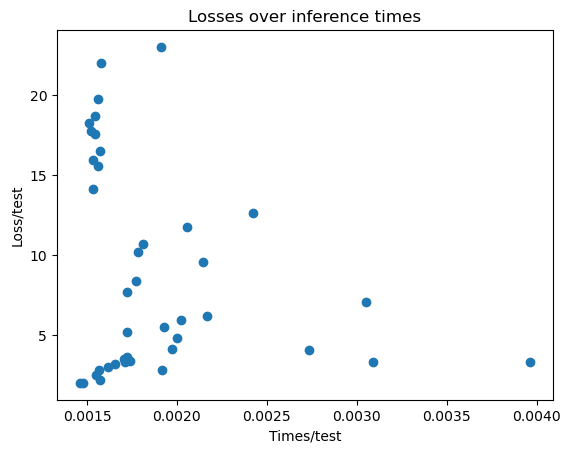

In [7]:
state_dict = torch.load('results/voc_fused_7_frozen_layers_300_epochs_00003_lr_0001_decay.pt')

net = PrunedMyTinyYoloV2(num_classes=1)
net.load_state_dict(state_dict)
net.to(device)

ratio = 0.03
lr = 0.00002
weight_decay = 0.001

t1 = time.time()

accuracy, times, losses, train_losses = [], [], [], []

prune_every = 10
prune_times = 40

criterion = YoloLoss(anchors=net.anchors)

frozen_layers = ['1', '2', '3', '4', '5', '6', '7']
nr_frozen = len(frozen_layers)


for key, param in net.named_parameters():
    if any(x in key for x in frozen_layers):
        param.requires_grad = False
    
optimizer = torch.optim.Adam(filter(lambda x: x.requires_grad, net.parameters()), lr=lr, weight_decay=weight_decay)


last_ten_sds = []
sds = []
time_threshold = 0.0015


#iterative pruning

#acc, t = net_acc_and_time(PrunedMyTinyYoloV2, state_dict, VOCDataLoaderPerson(train=False, batch_size=1, shuffle=True), batches=8)#, device='cuda')
#print(f"Acc: {acc}, Time: {t}")
l = 0
t = 1
torch_input = torch.randn(1, 3, 320, 320)


for i in range(prune_times * prune_every):
    print(f"Epoch {i + 1}/{prune_times * prune_every}")
    if i % prune_every == 0:
        state_dict = l1_structured_pruning(net.cpu().state_dict(), ratio)
        state_dict = densify_state_dict(state_dict)
        net.load_state_dict(state_dict)
        if int((i / prune_every)) % 5 == 0:
            torch.save(state_dict, f'results/voc_pruned_{int((i / prune_every))}_7_frozen_layers_300_epochs_00003_lr_001_decay.pt')
            onnx_program = torch.onnx.export(net, torch_input, f"results/voc_pruned_{int((i / prune_every))}_7_frozen_layers_300_epochs_00003_lr_0001_decay.onnx", input_names = ['input'])

    net, train_loss = train(net, VOCDataLoaderPerson(train=True, batch_size=256, shuffle=True), optimizer, criterion, device=device)
    train_losses.append(train_loss)

        
    if i % prune_every == prune_every - 1:
        p, r, l, t  = validate(net, VOCDataLoaderPerson(train=False, batch_size=1, shuffle=True), optimizer, criterion, device=device)

        acc = ap(p, r)
        
        
        #accuracy.append(acc)
        times.append(t)
        
        print('average time', t)
        print('average test losses', l)
        print('average precision', acc)
        losses.append(l)
        
    print('average train losses', train_loss)

    """
    if (l > 5):
        break

    if (t < time_threshold):
        sds.append(state_dict)
        time_threshold -= 0.0001

    if (t < 0.001):
        break

    last_ten_sds.append(state_dict)
    if (len(last_ten_sds) > 10):
        last_ten_sds.pop(0)

    
    if (len(times) >= 10):
        if (np.mean(times[-10:-5]) < np.mean(times[-5:])):
            index = torch.argmax(torch.FloatTensor(times[-10:]))
            best_sd = last_ten_sds[index]
            break"""
            

    
    
plot_losses_over_time(losses, times)

In [ ]:
plot([(list(range(len(losses))), losses, 'loss')],
      xlabel='index', save_path='retrainingloss.png')
plot([(list(range(len(times))), times, 'time')],
      xlabel='index', save_path='retrainingtime.png')
plot([(list(range(len(train_losses))), train_losses, 'train loss')],
      xlabel='index', save_path='retrainingtrainloss.png')

In [ ]:
means = []
means2 = []
for i in range(4):
    means.append(0.00142)
    means2.append(0.00142)
for i in range(4):
    means2.append(0.00142)
for i in range(4, len(times)):
    means.append(np.mean(times[i - 4:i+1]))
    means2.append(np.mean(times[i - 4:i+1]))


for i in range(4):
    means2.pop()

'''plot([(list(range(len(means))), means, 'means')],
      xlabel='index', save_path='retrainingmeans.png')
plot([(list(range(len(means2))), means2, 'means2')],
      xlabel='index', save_path='retrainingmeans2.png')
plot([(list(range(len(times))), times, 'time')],
      xlabel='index', save_path='retrainingtime.png')'''


plt.plot(list(range(len(times))), times, color='b', label='times') 
plt.plot(list(range(len(means))), means, color='r', label='means') 
plt.plot(list(range(len(means2))), means2, color='g', label='means2') 
plt.grid()


In [ ]:
torch.save(best_sd, 'models/configs/voc_pruned4.pt')